2.1 Carga de datos y librerias

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1. Configuración de Visualización
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)

# 2. Configuración de Rutas
BASE_DIR = Path.cwd().parent
RAW_DIR = BASE_DIR / "data" / "raw"
PROCESSED_DIR = BASE_DIR / "data" / "processed"

print("--- SCRIPT 1: CARGA DE DATOS ---")

try:
    # A. Cargar Bases Demográficas
    df_train = pd.read_parquet(PROCESSED_DIR / "abt_train.parquet")
    df_oot = pd.read_parquet(PROCESSED_DIR / "abt_oot.parquet")
    
    # B. Cargar Fuente de Gestiones
    df_gestiones = pd.read_parquet(RAW_DIR / "cbros_ct_gestiones_procesadas_masked")

    
    if 'id_masked' in df_train.columns:
        df_train['id_masked'] = df_train['id_masked'].astype(str)
    
    if 'id_masked' in df_gestiones.columns:
        df_gestiones['id_masked'] = df_gestiones['id_masked'].astype(str)
        
    if 'ID' in df_oot.columns:
        df_oot['ID'] = df_oot['ID'].astype(str)
    elif 'id_masked' in df_oot.columns:
        df_oot['id_masked'] = df_oot['id_masked'].astype(str)

    print(f"✅ ABT Train cargada {df_train.shape}")
    print(f"✅ ABT OOT cargada {df_oot.shape}")
    print(f"✅ Gestiones cargadas {df_gestiones.shape}")
    

except Exception as e:
    print(f"Error al cargar los archivos: {e}")

--- SCRIPT 1: CARGA DE DATOS ---
✅ ABT Train cargada (201977, 49)
✅ ABT OOT cargada (41957, 45)
✅ Gestiones cargadas (528546, 8)


2.2 Identificacion de Variables tabla Transacional

In [14]:
print("--- SCRIPT 2: AUDITORÍA E IDENTIFICACIÓN DE VARIABLES ---")

def inspect_dataset(df, name):
    print(f"\n INSPECCIÓN DE: {name}")
    print(f"   Dimensiones: {df.shape}")
    
    # 1. Revisión de Nulos
    nulos = df.isnull().sum()
    nulos = nulos[nulos > 0].sort_values(ascending=False)
    if not nulos.empty:
        print(f"   Columnas con Nulos (Top 3):")
        print(nulos.head(3))
    else:
        print("   Sin nulos.")

    # 2. Revisión de Tipos de IDs (Crítico para el cruce)
    cols_id = [c for c in df.columns if 'id' in c.lower() or 'mask' in c.lower()]
    print(f"   Columnas de ID detectadas: {cols_id}")
    for col in cols_id:
        print(f"      -> Tipo: {df[col].dtype} | Ejemplo: {df[col].iloc[0]}")

# 1. Inspección General
inspect_dataset(df_train, "TRAIN (Demográfico)")
inspect_dataset(df_gestiones, "GESTIONES (Transaccional)")

print("\n--- DETALLE DE LA TABLA GESTIONES ---")
display(df_gestiones.head(3))

print("\nValores únicos en columna de Resultado:")
# Ajusta el nombre de la columna si ves que es diferente en el head()
if 'contacto_cliente' in df_gestiones.columns:
    print(df_gestiones['contacto_cliente'].value_counts())

print("\nValores únicos en columna Canal:")
if 'canal' in df_gestiones.columns:
    print(df_gestiones['canal'].unique())

--- SCRIPT 2: AUDITORÍA E IDENTIFICACIÓN DE VARIABLES ---

 INSPECCIÓN DE: TRAIN (Demográfico)
   Dimensiones: (201977, 49)
   Columnas con Nulos (Top 3):
estado_cuenta    30676
antiguedad           7
edad                 5
dtype: int64
   Columnas de ID detectadas: ['id_masked']
      -> Tipo: str | Ejemplo: 1380371239760879104

 INSPECCIÓN DE: GESTIONES (Transaccional)
   Dimensiones: (528546, 8)
   Columnas con Nulos (Top 3):
tipo_telefono    56488
id_masked            1
dtype: int64
   Columnas de ID detectadas: ['id_masked']
      -> Tipo: str | Ejemplo: -2.307530672797584e+18

--- DETALLE DE LA TABLA GESTIONES ---


,id_masked,timestamp_gestion,accion,resultado,contacto_cliente,canal,tipo_terminal,tipo_telefono
0,-2.307530672797584e+18,2024-10-10 01:07:26.301,b'0007 Llamada a Celular Deudor',b'0002 Tel\xc3\xa9fono no contesta',0,b'LINEA TELEFONICA',b'Fijo',b'LABORAL'
1,-5.193638112521987e+18,2024-10-28 00:49:40.301,b'0004 Llamada a Oficina Deudor',b'0006 Tercero proporciona Datos',0,b'LINEA TELEFONICA',b'Fijo',b'RESIDENCIAL'
2,-5.193638112521987e+18,2024-10-23 01:18:02.301,b'0004 Llamada a Oficina Deudor',b'0006 Tercero proporciona Datos',0,b'LINEA TELEFONICA',b'Fijo',b'RESIDENCIAL'



Valores únicos en columna de Resultado:
contacto_cliente
0    435503
1     93043
Name: count, dtype: int64

Valores únicos en columna Canal:
[b'LINEA TELEFONICA' b'WHATSAPP']


2.3 Limpieza y estandarizacion

In [15]:
print("--- SCRIPT 3: LIMPIEZA Y ESTANDARIZACIÓN DE GESTIONES ---")

print("1. Estandarizando IDs...")
df_gestiones['id_masked'] = df_gestiones['id_masked'].astype(float).astype('Int64').astype(str)

# 2. Decodificación de Textos (Eliminar b'...')
print("2. Decodificando columnas de texto (Bytes -> String)...")
cols_bytes = ['accion', 'resultado', 'canal', 'tipo_terminal', 'tipo_telefono']

for col in cols_bytes:
    if col in df_gestiones.columns:
        # Aplicamos la decodificación solo si detectamos que son bytes
        df_gestiones[col] = df_gestiones[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# 3. Creación de Llave Temporal (Para unir mes a mes con los clientes)
print("3. Generando llave temporal (Month Key)...")
df_gestiones['timestamp_gestion'] = pd.to_datetime(df_gestiones['timestamp_gestion'])
df_gestiones['month_key'] = df_gestiones['timestamp_gestion'].dt.to_period('M')

# 4. Verificación de Resultados
print("\n--- VALIDACIÓN POST-LIMPIEZA ---")
print(f"Nuevo tipo de ID: {df_gestiones['id_masked'].dtype}")
print(f"Ejemplo de ID: {df_gestiones['id_masked'].iloc[0]}")
print(f"Meses disponibles: {df_gestiones['month_key'].unique()}")

print("\nMuestra de textos limpios:")
display(df_gestiones[['id_masked', 'canal', 'resultado']].head(3))

--- SCRIPT 3: LIMPIEZA Y ESTANDARIZACIÓN DE GESTIONES ---
1. Estandarizando IDs...
2. Decodificando columnas de texto (Bytes -> String)...
3. Generando llave temporal (Month Key)...

--- VALIDACIÓN POST-LIMPIEZA ---
Nuevo tipo de ID: str
Ejemplo de ID: -2307530672797583872
Meses disponibles: <PeriodArray>
['2024-10', '2024-11', '2024-12', '2024-09']
Length: 4, dtype: period[M]

Muestra de textos limpios:


,id_masked,canal,resultado
0,-2307530672797583872,LINEA TELEFONICA,0002 Teléfono no contesta
1,-5193638112521987072,LINEA TELEFONICA,0006 Tercero proporciona Datos
2,-5193638112521987072,LINEA TELEFONICA,0006 Tercero proporciona Datos


2.4 Creacion de variables de compartamiento MoM

In [16]:
print("--- SCRIPT 4: CREACIÓN DE VARIABLES DE COMPORTAMIENTO ---")

# 1. Definición de la lógica de agregación
# Agrupamos por Cliente (id_masked) y por Mes (month_key)

print("Agrupando historia de gestiones...")

df_behavior = df_gestiones.groupby(['id_masked', 'month_key']).agg(
    # Volumetría: ¿Cuánto llamamos?
    intentos_totales=('id_masked', 'count'),
    
    # Efectividad: ¿Cuántas veces contestó? 
    contactos_exitosos=('contacto_cliente', 'sum'),
    
    # Preferencia de Canal: Conteo específico
    intentos_tel=('canal', lambda x: (x == 'LINEA TELEFONICA').sum()),
    intentos_wapp=('canal', lambda x: (x == 'WHATSAPP').sum()),
    
    # Comportamiento Horario: ¿A qué hora fue el último intento?
    hora_ultimo_intento=('timestamp_gestion', lambda x: x.max().hour)
).reset_index()

# 2. Creación de Ratios (Variables Relativas)
print("Calculando KPIs de eficiencia...")

# Tasa de Éxito (Hit Rate): De cada 10 llamadas, ¿cuántas contesta?
df_behavior['hit_rate_mensual'] = df_behavior['contactos_exitosos'] / df_behavior['intentos_totales']

# Preferencia de Canal (%): ¿Qué tanto usamos el teléfono con él?
df_behavior['ratio_uso_telefono'] = df_behavior['intentos_tel'] / df_behavior['intentos_totales']

# Flag Horario: ¿Es un cliente "Mañanero"? (Antes de las 12pm)
df_behavior['es_cliente_manana'] = (df_behavior['hora_ultimo_intento'] < 12).astype(int)

# 3. Validación de Resultados
print("\n--- RESUMEN DE COMPORTAMIENTO ---")
print(f"Combinaciones Cliente-Mes generadas: {df_behavior.shape[0]}")
print("\nEstadísticas del Hit Rate (Tasa de Éxito):")
print(df_behavior['hit_rate_mensual'].describe())

print("\nEjemplo de 3 clientes:")
display(df_behavior.head(3))

--- SCRIPT 4: CREACIÓN DE VARIABLES DE COMPORTAMIENTO ---
Agrupando historia de gestiones...
Calculando KPIs de eficiencia...

--- RESUMEN DE COMPORTAMIENTO ---
Combinaciones Cliente-Mes generadas: 201978

Estadísticas del Hit Rate (Tasa de Éxito):
count    201978.000000
mean          0.118979
std           0.273477
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: hit_rate_mensual, dtype: float64

Ejemplo de 3 clientes:


,id_masked,month_key,intentos_totales,contactos_exitosos,intentos_tel,intentos_wapp,hora_ultimo_intento,hit_rate_mensual,ratio_uso_telefono,es_cliente_manana
0,-1000301770983318016,2024-10,6,2,3,3,0,0.333333,0.500000,1
1,-1000301770983318016,2024-11,2,1,2,0,1,0.500000,1.000000,1
2,-1000301770983318016,2024-12,11,5,7,4,1,0.454545,0.636364,1


2.4.1 Analisis estrategico de tabla gestiones (Preguntas 4 - 7)

--- SCRIPT 4.1: ANÁLISIS ESTRATÉGICO DE CONTACTABILIDAD ---


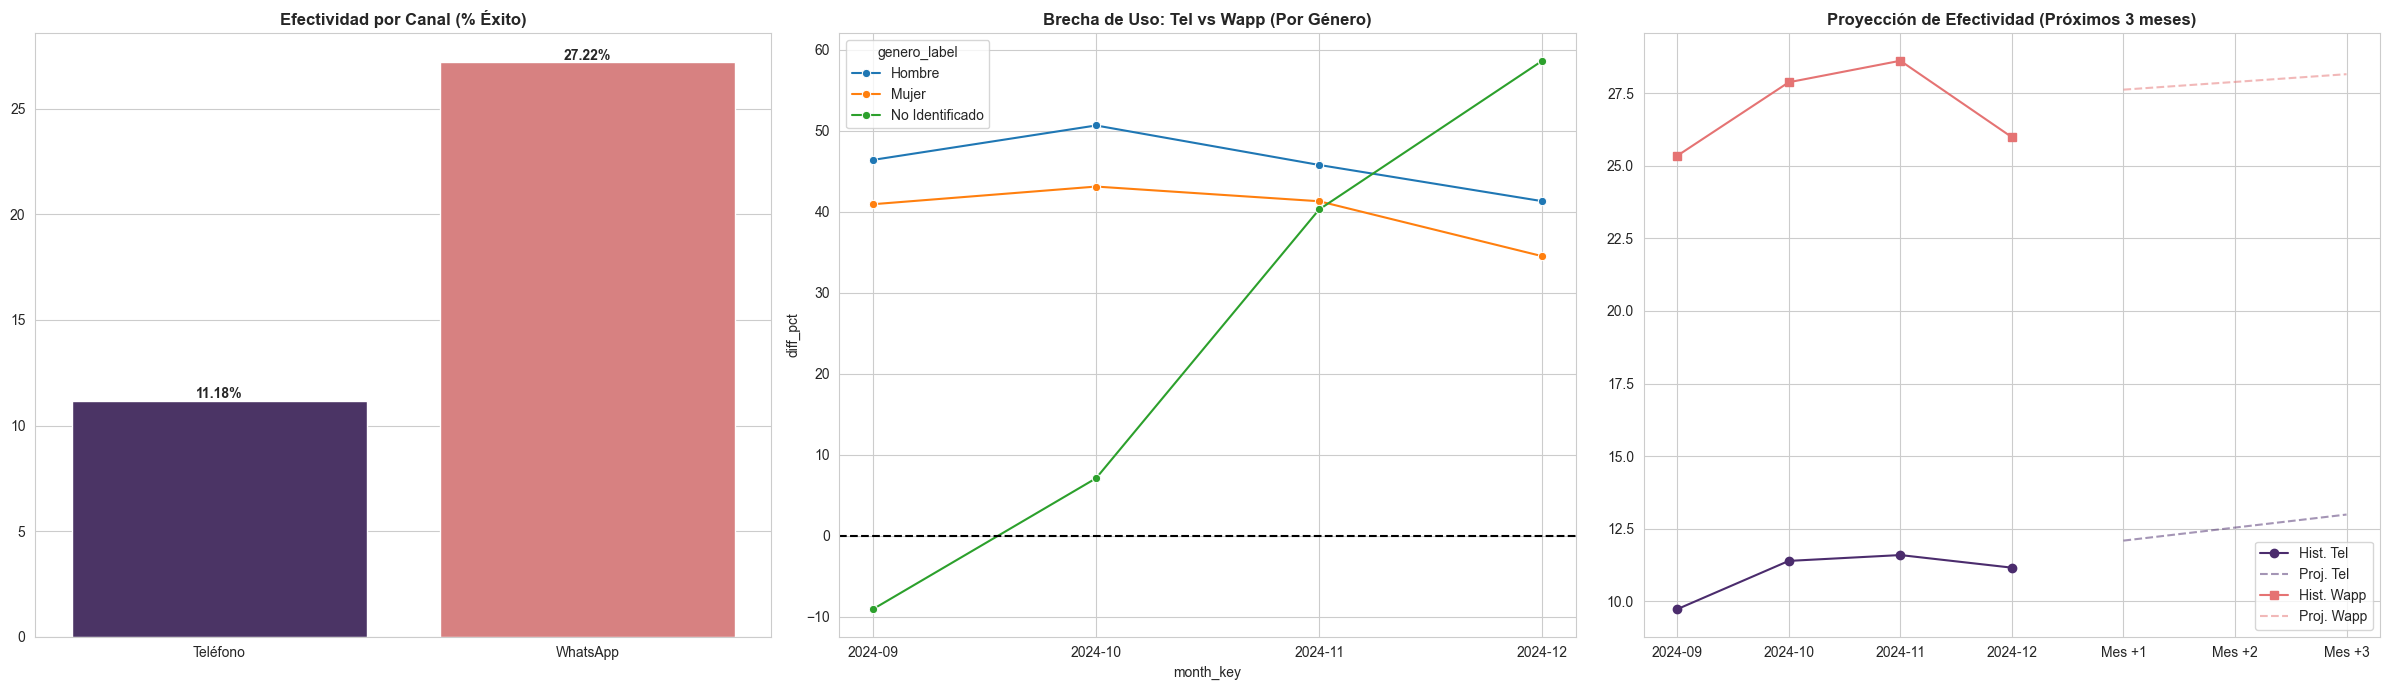

In [17]:
print("--- SCRIPT 4.1: ANÁLISIS ESTRATÉGICO DE CONTACTABILIDAD ---")

# 1. Definición de Éxito basada en el Top 20 resultados 
# (Códigos identificados en el EDA: 0391, 0037, 0006, 0007, 0855, 1001)
CODIGOS_EXITO = ['0391', '0037', '0006', '0007', '0855', '1001']
regex_exito = '|'.join(CODIGOS_EXITO)

# Marcamos éxitos en la tabla de gestiones que ya limpiaste en el Script 3
df_gestiones['es_exito'] = df_gestiones['resultado'].str.contains(regex_exito, na=False)

# Re-agrupamos para obtener éxitos por canal y mes
negocio_agg = df_gestiones.groupby(['id_masked', 'month_key']).agg(
    exitos_tel=('es_exito', lambda x: (x & (df_gestiones.loc[x.index, 'canal'] == 'LINEA TELEFONICA')).sum()),
    exitos_wapp=('es_exito', lambda x: (x & (df_gestiones.loc[x.index, 'canal'] == 'WHATSAPP')).sum())
).reset_index()

# Unimos temporalmente con df_train para tener el Género
df_analisis = pd.merge(
    df_train[['id_masked', 'month_key', 'genero_label']], 
    df_behavior[['id_masked', 'month_key', 'intentos_tel', 'intentos_wapp']], 
    on=['id_masked', 'month_key']
)
df_analisis = pd.merge(df_analisis, negocio_agg, on=['id_masked', 'month_key'])

# --- CÁLCULOS PARA GRÁFICOS ---
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# A. Canal más efectivo (Pregunta 1 y 2)
efec_t = (df_analisis['exitos_tel'].sum() / df_analisis['intentos_tel'].sum()) * 100
efec_w = (df_analisis['exitos_wapp'].sum() / df_analisis['intentos_wapp'].sum()) * 100

sns.barplot(x=['Teléfono', 'WhatsApp'], y=[efec_t, efec_w], palette=['#4b2c6d', '#e57373'], ax=axes[0], hue=['Teléfono', 'WhatsApp'], legend=False)
axes[0].set_title('Efectividad por Canal (% Éxito)', fontweight='bold')
for i, v in enumerate([efec_t, efec_w]):
    axes[0].text(i, v + 0.1, f'{v:.2f}%', ha='center', fontweight='bold')

# B. Diferencia porcentual por Género y Mes (Pregunta 3)
df_brecha = df_analisis.groupby(['month_key', 'genero_label']).agg({'intentos_tel':'sum', 'intentos_wapp':'sum'}).reset_index()
df_brecha['diff_pct'] = ((df_brecha['intentos_tel'] - df_brecha['intentos_wapp']) / (df_brecha['intentos_tel'] + df_brecha['intentos_wapp']).replace(0,1)) * 100

sns.lineplot(data=df_brecha, x=df_brecha['month_key'].astype(str), y='diff_pct', hue='genero_label', marker='o', ax=axes[1])
axes[1].set_title('Brecha de Uso: Tel vs Wapp (Por Género)', fontweight='bold')
axes[1].axhline(0, color='black', linestyle='--')

# C. Proyección de Efectividad a 3 meses (Pregunta 4)
df_tend = df_analisis.groupby('month_key').agg({'exitos_tel':'sum', 'intentos_tel':'sum', 'exitos_wapp':'sum', 'intentos_wapp':'sum'}).reset_index()
df_tend['ef_t'] = (df_tend['exitos_tel'] / df_tend['intentos_tel'].replace(0,1)) * 100
df_tend['ef_w'] = (df_tend['exitos_wapp'] / df_tend['intentos_wapp'].replace(0,1)) * 100

x = np.arange(len(df_tend))
x_proj = np.arange(len(df_tend), len(df_tend) + 3)
p_t = np.poly1d(np.polyfit(x, df_tend['ef_t'], 1))
p_w = np.poly1d(np.polyfit(x, df_tend['ef_w'], 1))

axes[2].plot(df_tend['month_key'].astype(str), df_tend['ef_t'], label='Hist. Tel', color='#4b2c6d', marker='o')
axes[2].plot(['Mes +1', 'Mes +2', 'Mes +3'], p_t(x_proj), '--', color='#4b2c6d', alpha=0.5, label='Proj. Tel')
axes[2].plot(df_tend['month_key'].astype(str), df_tend['ef_w'], label='Hist. Wapp', color='#e57373', marker='s')
axes[2].plot(['Mes +1', 'Mes +2', 'Mes +3'], p_w(x_proj), '--', color='#e57373', alpha=0.5, label='Proj. Wapp')
axes[2].set_title('Proyección de Efectividad (Próximos 3 meses)', fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

2.5 Integración de Comportamiento Histórico (Lag)

In [18]:
print("--- SCRIPT 5: CRUCE CON LAG  ---")

# 1. Crear el Lag directamente con los objetos Period
temp_behavior = df_behavior.copy()

# En Pandas, si sumas 1 a un Periodo de mes, te da el mes siguiente automáticamente
# '2024-10' + 1 = '2024-11'
temp_behavior['month_key_target'] = temp_behavior['month_key'] + 1

# Limpieza: quitamos la llave original para no confundir al merge
temp_behavior = temp_behavior.drop(columns=['month_key'])

# 2. Cruce para TRAIN
print("1. Cruzando Train con historia del mes anterior...")
# Aseguramos que month_key en df_train sea del mismo tipo que en temp_behavior
df_train['month_key'] = pd.PeriodIndex(df_train['month_key'], freq='M')

df_train_final = pd.merge(
    df_train,
    temp_behavior,
    left_on=['id_masked', 'month_key'],
    right_on=['id_masked', 'month_key_target'],
    how='left'
).drop(columns=['month_key_target'])

# 3. Cruce para OOT (Última foto disponible)
print("2. Cruzando OOT con el último comportamiento conocido...")
df_behavior_sorted = df_behavior.sort_values(by=['id_masked', 'month_key'], ascending=[True, False])
df_last_known = df_behavior_sorted.drop_duplicates(subset=['id_masked'], keep='first').copy()
df_last_known = df_last_known.drop(columns=['month_key'])

df_oot_final = pd.merge(
    df_oot,
    df_last_known,
    on='id_masked',
    how='left'
)

# 4. Imputación de Ceros
cols_comportamiento = [
    'intentos_totales', 'contactos_exitosos', 'hit_rate_mensual', 
    'intentos_tel', 'intentos_wapp', 'ratio_uso_telefono', 
    'es_cliente_manana', 'hora_ultimo_intento'
]

for col in cols_comportamiento:
    df_train_final[col] = df_train_final[col].fillna(0)
    df_oot_final[col] = df_oot_final[col].fillna(0)

# Convertimos month_key a string al final para que no de problemas al guardar en Parquet
df_train_final['month_key'] = df_train_final['month_key'].astype(str)

print(f"\n✅ Cruce terminado con éxito.")
print(f"Match Rate Real en Train: {(df_train_final['intentos_totales'] > 0).mean():.2%}")

--- SCRIPT 5: CRUCE CON LAG  ---
1. Cruzando Train con historia del mes anterior...
2. Cruzando OOT con el último comportamiento conocido...

✅ Cruce terminado con éxito.
Match Rate Real en Train: 39.28%


2.6 Analisis avanzado de variables

--- SCRIPT 6: ANÁLISIS AVANZADO DE VARIABLES ---
Se detectaron 2 variables constantes. Se excluirán del análisis.
Analizando 31 variables válidas...

1. Generando Mapa de Redundancia (Clustermap)...


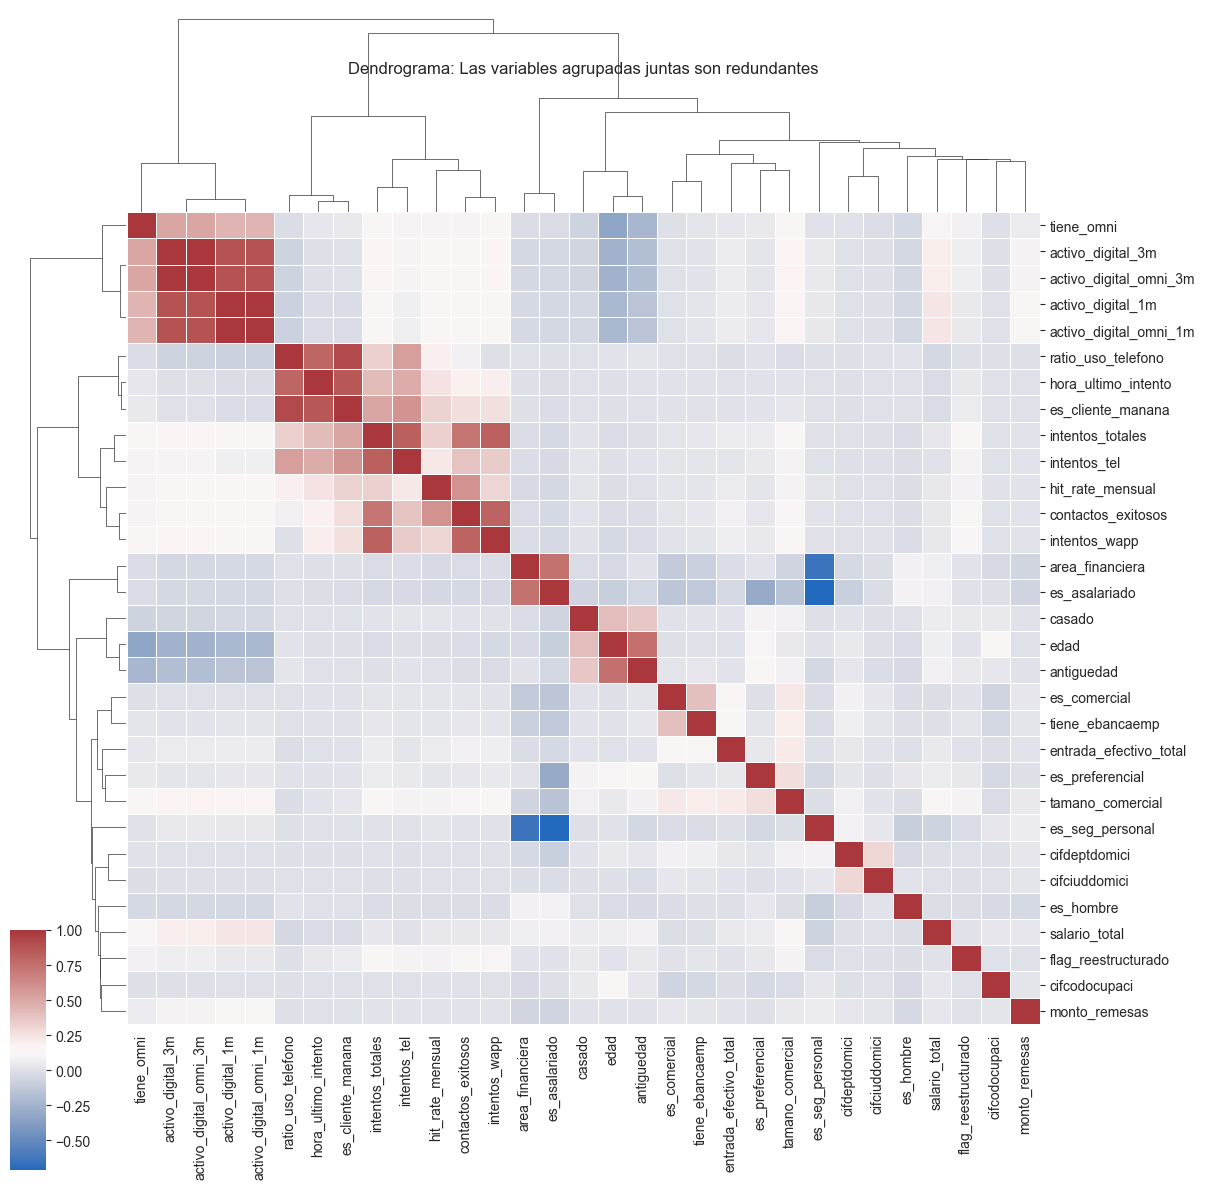


2. Calculando Importancia Real (Mutual Information)...


C:\Users\Nicole\AppData\Local\Temp\ipykernel_28036\4251817853.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_series.head(25), y=mi_series.head(25).index, palette='viridis')


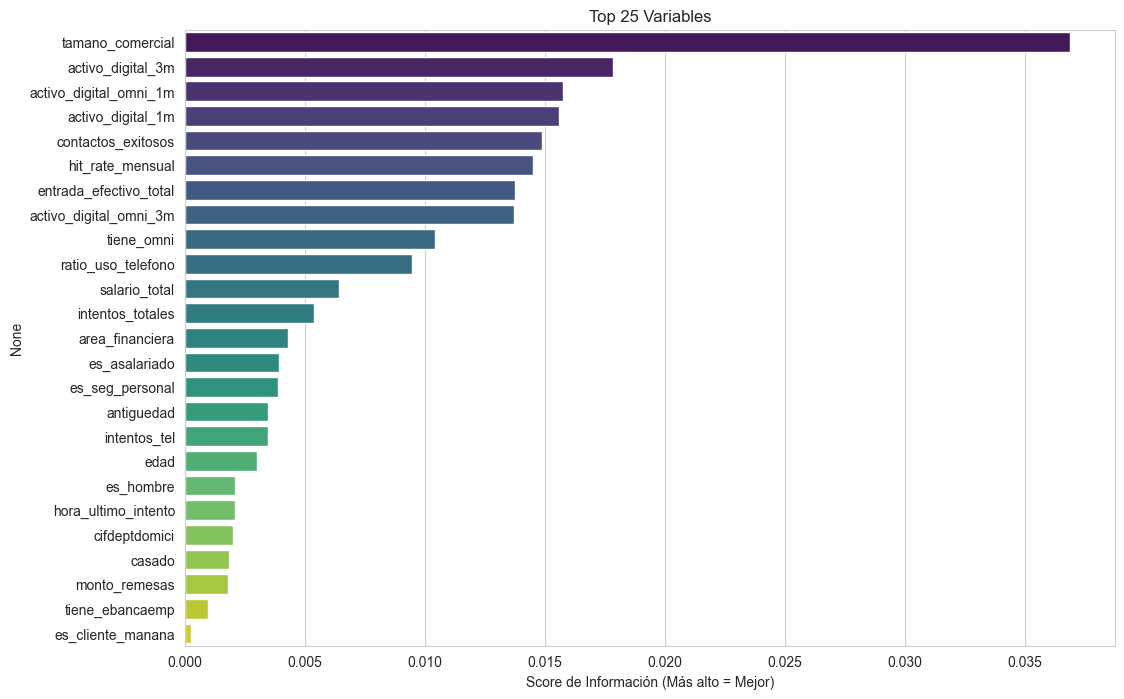


3. Verificación de Fugas (Leakage Check)...
No se detectó Leakage.


In [19]:
from sklearn.feature_selection import mutual_info_classif

print("--- SCRIPT 6: ANÁLISIS AVANZADO DE VARIABLES ---")

# 1. Preparación de datos
# Lista de exclusión técnica
exclude_cols = ['target', 'fecha_mes', 'fin_mes', 'month_key']
# Seleccionamos solo numéricas
cols_analisis = df_train_final.select_dtypes(include=[np.number]).columns.tolist()
cols_analisis = [c for c in cols_analisis if c not in exclude_cols]

# FILTRO: Eliminamos columnas constantes (Varianza 0) para evitar errores
std_dev = df_train_final[cols_analisis].std()
cols_constantes = std_dev[std_dev == 0].index.tolist()

if cols_constantes:
    print(f"Se detectaron {len(cols_constantes)} variables constantes. Se excluirán del análisis.")
    cols_analisis = [c for c in cols_analisis if c not in cols_constantes]

print(f"Analizando {len(cols_analisis)} variables válidas...")

# ---------------------------------------------------------
# A. DENDROGRAMA DE REDUNDANCIA (Variables vs Variables)
# ---------------------------------------------------------
print("\n1. Generando Mapa de Redundancia (Clustermap)...")

# Calculamos matriz solo entre features
corr_matrix = df_train_final[cols_analisis].corr().fillna(0)

# Graficamos
g = sns.clustermap(
    corr_matrix, 
    method='ward', 
    cmap='vlag', 
    dendrogram_ratio=(.1, .2),
    cbar_pos=(0, .02, .03, .2),
    linewidths=0.5, 
    figsize=(12, 12),
    yticklabels=True,
    xticklabels=True
)
g.ax_heatmap.set_title("Dendrograma: Las variables agrupadas juntas son redundantes", pad=100)
plt.show()

# ---------------------------------------------------------
# B. PODER PREDICTIVO REAL (Mutual Information)
# ---------------------------------------------------------
print("\n2. Calculando Importancia Real (Mutual Information)...")

# Muestra representativa
df_sample = df_train_final.sample(n=min(20000, len(df_train_final)), random_state=42).fillna(0)
X_mi = df_sample[cols_analisis]
y_mi = df_sample['target']

mi_scores = mutual_info_classif(X_mi, y_mi, random_state=42)
mi_series = pd.Series(mi_scores, index=X_mi.columns).sort_values(ascending=False)

# Graficamos Top 25
plt.figure(figsize=(12, 8))
sns.barplot(x=mi_series.head(25), y=mi_series.head(25).index, palette='viridis')
plt.title("Top 25 Variables")
plt.xlabel("Score de Información (Más alto = Mejor)")
plt.show()

# ---------------------------------------------------------
# C. DETECCIÓN AUTOMÁTICA DE LEAKAGE (Corregido)
# ---------------------------------------------------------
print("\n3. Verificación de Fugas (Leakage Check)...")

# Calculamos la correlación CONTRA el target específicamente
df_leakage = df_train_final[cols_analisis + ['target']].fillna(0)
leakage_corr = df_leakage.corr()['target'].abs().sort_values(ascending=False)
leakage_corr = leakage_corr.drop('target', errors='ignore')

# Filtramos las correlaciones sospechosas (> 0.90)
suspicious_vars = leakage_corr[leakage_corr > 0.90].index.tolist()

if suspicious_vars:
    print(f" ALERTA: Se detectaron {len(suspicious_vars)} variables con correlación extrema (>0.90).")
    print(f"Posible Leakage: {suspicious_vars}")
else:
    print("No se detectó Leakage.")

2.7 Optimizacion y guardado de datasets

In [20]:
print("--- SCRIPT 7: LIMPIEZA DE REDUNDANCIA Y GUARDADO ---")

# 1. Configuración de Umbrales
UMBRAL_CORRELACION = 0.95  # Si se parecen más del 95%, borramos una.

# 2. Identificación de Columnas Numéricas
exclude_cols = ['target', 'fecha_mes', 'fin_mes', 'month_key', 'id_masked']
numeric_cols = df_train_final.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in exclude_cols]

# 3. Detección de Variables Constantes (Varianza 0)
std_dev = df_train_final[numeric_cols].std()
cols_constantes = std_dev[std_dev == 0].index.tolist()

if cols_constantes:
    print(f"\n Eliminando {len(cols_constantes)} variables CONSTANTES (Varianza 0):")
    print(f"   {cols_constantes}")
    df_train_final.drop(columns=cols_constantes, inplace=True)
    df_oot_final.drop(columns=cols_constantes, inplace=True)
    # Actualizamos la lista de numéricas
    numeric_cols = [c for c in numeric_cols if c not in cols_constantes]

# 4. Detección y Eliminación de Redundantes (Multicolinealidad)
print(f"\n Buscando variables con correlación > {UMBRAL_CORRELACION})...")

corr_matrix = df_train_final[numeric_cols].corr().abs()

# Seleccionamos el triángulo superior de la matriz
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Buscamos columnas a eliminar (cualquiera que tenga > 0.95 con otra)
to_drop_redundant = [column for column in upper.columns if any(upper[column] > UMBRAL_CORRELACION)]

if to_drop_redundant:
    print(f" Eliminando {len(to_drop_redundant)} variables REDUNDANTES:")
    print(f"   {to_drop_redundant}")
    
    df_train_final.drop(columns=to_drop_redundant, inplace=True)
    df_oot_final.drop(columns=to_drop_redundant, inplace=True)
else:
    print("  No se encontraron redundancias graves.")

# 5. Limpieza de columnas técnicas sobrantes antes de guardar
cols_tecnicas = ['month_key', 'fin_mes', 'fecha_mes']
df_train_final.drop(columns=cols_tecnicas, errors='ignore', inplace=True)
df_oot_final.drop(columns=cols_tecnicas, errors='ignore', inplace=True)

# 6. Guardado Final
print("\nGuardando datasets optimizados...")
try:
    df_train_final.to_parquet(PROCESSED_DIR / "final_train_con_gestiones.parquet", index=False)
    df_oot_final.to_parquet(PROCESSED_DIR / "final_oot_con_gestiones.parquet", index=False)
    
    print(f" ¡ÉXITO! Archivos guardados en: {PROCESSED_DIR}")
    print(f"   - Train Final: {df_train_final.shape} columnas")
    print(f"   - OOT Final:   {df_oot_final.shape} columnas")
except Exception as e:
    print(f" Error al guardar: {e}")

--- SCRIPT 7: LIMPIEZA DE REDUNDANCIA Y GUARDADO ---

 Eliminando 2 variables CONSTANTES (Varianza 0):
   ['activo_digital_bm_1m', 'activo_digital_bm_3m']

 Buscando variables con correlación > 0.95)...
 Eliminando 2 variables REDUNDANTES:
   ['activo_digital_omni_1m', 'activo_digital_omni_3m']

Guardando datasets optimizados...
 ¡ÉXITO! Archivos guardados en: c:\Users\Nicole\Documents\Proyecto_BA\data\processed
   - Train Final: (201977, 50) columnas
   - OOT Final:   (41957, 48) columnas
